In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import seaborn as sns
import cvxpy as cp
import math

sns.set_theme()

In [3]:
def read_input(file_path, atleast_2d=False):
    # by default a row of numbers in loaded as a 1D vector
    data = np.loadtxt(file_path)
    if atleast_2d:
        if data.ndim == 1:
            data = data.reshape((1, -1))
    return data

In [4]:
poly_path = "PA-1-data-text/polydata_data_"
X_sample = read_input(f"{poly_path}sampx.txt", atleast_2d=True)
y_sample = read_input(f"{poly_path}sampy.txt")
X_poly = read_input(f"{poly_path}polyx.txt", atleast_2d=True)
y_poly = read_input(f"{poly_path}polyy.txt")

## Part 1: Polynomial function

For this part, we first define a base class for all of the regression models.

In [30]:
class Regression:
    """Abstract base class for all regression models.

    Suppose a scalar function f(x, θ) with an input x ∈ R^d and an unknown parameter
    θ ∈ R^D has the form
    
        f(x, θ) = ϕ(x)^T θ,
    
    where ϕ: R^d → R^D is a known feature transformation. Given a dataset of n pairs
    (x_i, y_i) of input and *noisy* output, our goal is to estimate the value of the
    parameter θ and use it to predict the output of the function with a new input x*.
    For convenience, we define three variables

        y = [y_1 ... y_n]^T,    Φ = [ϕ(x_1) ... ϕ(x_n)],    X = [x_1 ... x_n].

    The API here mirrors that of a model in scikit-learn with two main methods:
    - `fit(X, y)`: estimate the parameter using the given data (training)
    - `predict(x)`: predict the output corresponds to the given input (inference)
    """

    def __init__(self):
        # a R^d -> R^D feature transformation
        self.phi = None
        self.title = None
    
    def hyperparam(self):
        return None

    def fit(self, X, y):
        pass

    def predict(self, x):
        pass

### (a) Implement 5 regression algorithms

In [6]:
class LS(Regression):
    """Least Squares (LS) Regression

    This regression model aims to minimize the L2-norm of the difference between the
    given output and the output of the function, i.e.

       θ^_LS = argmin_θ ‖y - Φ^T θ‖^2
             = (ΦΦ^T)^(-1)Φy

    The prediction for input x* is then f* = ϕ(x*)^T θ^.
    """

    def __init__(self):
        self.title = f"Least Squares Regression"

    def fit(self, X, y):
        Phi = np.apply_along_axis(self.phi, 0, np.atleast_2d(X))
        inv = np.linalg.inv(Phi @ Phi.T)
        self.theta_hat = inv @ Phi @ y
        return self.theta_hat

    def predict(self, X):
        Phi = np.apply_along_axis(self.phi, 0, np.atleast_2d(X))
        return (Phi.T @ self.theta_hat, None)

In [31]:
class RLS(Regression):
    """Regularized Least Squares (RLS) Regression

    This regression model aims to minimize the L2-norm of the difference between the
    real and the predicted outputs, together with the L2-norm of the parameter as a
    penalty term, i.e.,

       θ^_LS = argmin_θ ‖y - Φ^T θ‖^2 + λ‖θ‖^2
             = (ΦΦ^T + λI)^(-1)Φy

    Here, λ is a hyperparameter. The prediction for input x* is then f* = ϕ(x*)^T θ^.
    """
    def __init__(self, l=None):
        self.title = f"RLS Regression (λ={l:.2f})"
        self.l = l
    
    def hyperparam(self):
        return super().hyperparam() or self.l

    def fit(self, X, y):
        Phi = np.apply_along_axis(self.phi, 0, np.atleast_2d(X))
        D = Phi.shape[0]
        inv = np.linalg.inv(Phi @ Phi.T + self.l * np.identity(D))
        self.theta_hat = inv @ Phi @ y
        return self.theta_hat

    def predict(self, X):
        Phi = np.apply_along_axis(self.phi, 0, np.atleast_2d(X))
        return (Phi.T @ self.theta_hat, None)

In [32]:
class LASSO(Regression):
    """LASSO Regression

    This regression model aims to minimize the L2-norm of the difference between the
    real and the predicted outputs, together with the L1-norm of the parameter as a
    penalty term, i.e.,

        θ^_LASSO = argmin_θ ‖y - Φ^T θ‖^2 + λ‖θ‖_1

    Here, λ is a hyperparameter. The prediction for input x* is then f* = ϕ(x*)^T θ^.
    This optimization problem does not have a closed form solution and requires
    quadratic programming to estimate its solution.
    """

    def __init__(self, l=None):
        self.title = f"LASSO Regression (λ={l:.2f})"
        self.l = l
    
    def hyperparam(self):
        return super().hyperparam() or self.l

    def fit(self, X, y):
        Phi = np.apply_along_axis(self.phi, 0, np.atleast_2d(X))
        D = Phi.shape[0]
        Phi_Phi_T = Phi @ Phi.T
        Phi_y = Phi @ y

        H = np.block([[Phi_Phi_T, -Phi_Phi_T], [-Phi_Phi_T, Phi_Phi_T]])
        f = self.l - np.block([Phi_y, -Phi_y])
        x = cp.Variable(2*D)

        # To avoid cases where cvxpy fails to assert H is positive semidefinite
        # due to numerical issues. See https://github.com/cvxpy/cvxpy/issues/1995
        H_psd = cp.psd_wrap(H)

        objective = cp.Minimize(cp.quad_form(x, H_psd) + 2 * f.T @ x)
        constraints = [x >= 0]
        problem = cp.Problem(objective, constraints)
        problem.solve(solver=cp.OSQP)

        self.theta_hat = x.value[:D] - x.value[D:]
        return self.theta_hat

    def predict(self, X):
        Phi = np.apply_along_axis(self.phi, 0, np.atleast_2d(X))
        return (Phi.T @ self.theta_hat, None)

In [9]:
class RR(Regression):
    """Robust Regression

    This regression model aims to minimize the L1-norm of the difference between the
    real and the predicted outputs, i.e.,

        θ^_RR = argmin_θ ‖y - Φ^T θ‖_1

    The prediction for input x* is then f* = ϕ(x*)^T θ^. This optimization problem does
    not have a closed form solution and requires linear programming to estimate its
    solution.
    """

    def __init__(self):
        self.title = f"Robust Regression"

    def fit(self, X, y):
        Phi = np.apply_along_axis(self.phi, 0, np.atleast_2d(X))
        D, n = Phi.shape

        A = np.block([[-Phi.T, -np.identity(n)], [Phi.T, -np.identity(n)]])
        f = np.block([np.zeros(D), np.ones(n)])
        b = np.block([-y, y])
        x = cp.Variable(D+n)

        objective = cp.Minimize(f @ x)
        constraints = [A @ x <= b]
        problem = cp.Problem(objective, constraints)
        problem.solve(solver=cp.CLARABEL)

        self.theta_hat = x.value[:D]
        return self.theta_hat

    def predict(self, X):
        Phi = np.apply_along_axis(self.phi, 0, np.atleast_2d(X))
        return (Phi.T @ self.theta_hat, None)

In [33]:
class BR(Regression):
    """Bayesian Regression

    This regression model aims to update its prior beliefs about the parameter using
    the given data to produce the posterior distribution of the parameter. Suppose θ
    has multivariate i.i.d. Gaussian prior distribution θ ~ N(0, αI) and the observed
    outputs have Gaussian noises with constant variance added to the "true" output,
    i.e., the sampling distribution is y|x,θ ~ N(f(x,θ), σ^2). Then, the posterior is

        θ|X,y ~ N(μ^_θ, Σ^_θ^2)
        μ^_θ = σ^(-2) Σ^_θ Φy
        Σ^_θ = (α^(-1)I + σ^(-2)ΦΦ^T)^(-1)

    The predictive distribution for input x* is a Gaussian, with

        f*|X,y,x* ~ N(μ^*, σ^*^2)
        μ^* = ϕ(x*)^T μ^_θ
        σ^*^2 = ϕ(x*)^T Σ^_θ ϕ(x*)
    """

    def __init__(self, alpha=None, sigma_2=None):
        self.title = f"Bayesian Regression (α={alpha:.1f}, σ²={sigma_2:.1f})"
        self.alpha = alpha
        self.sigma_2 = sigma_2
    
    def hyperparam(self):
        return super().hyperparam() or (self.alpha, self.sigma_2)

    def fit(self, X, y):
        Phi = np.apply_along_axis(self.phi, 0, np.atleast_2d(X))
        Phi_Phi_T = Phi @ Phi.T
        D = Phi.shape[0]

        self.Sigma_hat_theta = np.linalg.inv(np.identity(D) / self.alpha + Phi_Phi_T / self.sigma_2)
        self.mu_hat_theta = self.Sigma_hat_theta @ Phi @ y / self.sigma_2
        return self.mu_hat_theta

    def predict(self, X):
        Phi = np.apply_along_axis(self.phi, 0, np.atleast_2d(X))
        mu_hat = (Phi.T @ self.mu_hat_theta).reshape((-1,))
        sigma_2_hat = np.diag(Phi.T @ self.Sigma_hat_theta @ Phi)
        return (mu_hat, sigma_2_hat)

### (b) Fit, predict, and plot

We now define our polynomial feature transformation with degree 5 to be used for the models.

In [11]:
poly_5 = lambda x: x[0]**np.array(range(6))

Least Squares Regression
Mean squared error: 0.4086438835698628
----------------------------------------
RLS Regression (λ=0.10)
Mean squared error: 0.40823651820258716
----------------------------------------
LASSO Regression (λ=0.20)
Mean squared error: 0.41912229862967637
----------------------------------------
Robust Regression
Mean squared error: 0.7680463117516118
----------------------------------------
Bayesian Regression (α=1.0, σ²=0.4)
Mean squared error: 0.4076268831718175
----------------------------------------


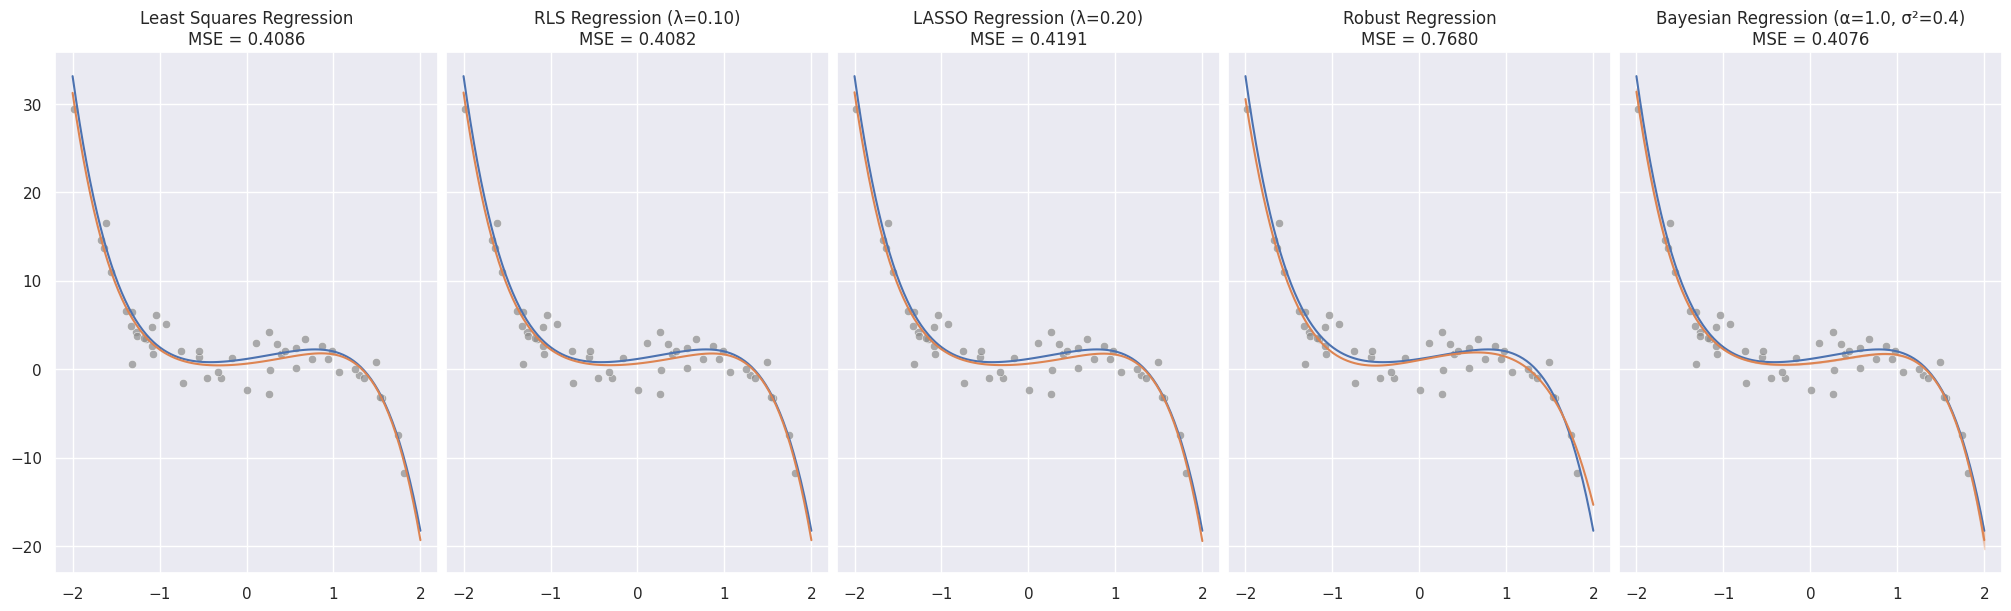

In [14]:
def fit_predict_plot(models, phi):
    fig, axs = plt.subplots(1, len(models), figsize=(len(models) * 4, 6), sharey=True, constrained_layout=True)
    for model, ax in zip(models, axs):
        model.phi = phi
        result = model.fit(X_sample, y_sample)    
        (y_poly_predict, std) = model.predict(X_poly)
        mse = np.square(y_poly - y_poly_predict).mean()

        print(model.title)
        print(f"Mean squared error: {mse}")
        print("-" * 40)

        X_poly_1d = X_poly.reshape((-1,))
        colors = sns.color_palette()

        sns.lineplot(x=X_poly_1d, y=y_poly, color=colors[0], ax=ax)
        sns.lineplot(x=X_poly_1d, y=y_poly_predict, color=colors[1], ax=ax)
        if std is not None:
            ax.fill_between(X_poly_1d, y_poly_predict - std, y_poly_predict + std, color=colors[1], alpha=0.3)
        sns.scatterplot(x=X_sample.reshape((-1,)), y=y_sample, alpha=0.7, color=colors[7], ax=ax)
        ax.set_title(f"{model.title}\nMSE = {mse:.4f}")

models_1b = [LS(), RLS(l=0.1), LASSO(l=0.2), RR(), BR(alpha=1, sigma_2=0.4)]
fit_predict_plot(models_1b, phi=poly_5)

### (c) Smaller training data

Least Squares Regression
Estimated parameter:
[ 0.90147022 -0.91793895  0.58298774  2.70971214  0.32680561 -1.65359133]
Mean squared error: 3.356982691130165
------------------------------------------------------------------------
RLS Regression (λ=1.00)
Estimated parameter:
[ 0.47304918  0.72917598  0.79971631  0.80888706  0.27326746 -1.19148118]
Mean squared error: 1.6366987693857311
------------------------------------------------------------------------
LASSO Regression (λ=1.00)
Estimated parameter:
[ 0.06794901  1.13674358  1.36648591  0.30659699  0.10661263 -1.05976281]
Mean squared error: 1.3923471465010828
------------------------------------------------------------------------
Robust Regression
Estimated parameter:
[ 2.73499939 -5.20417713 -0.70704935  7.4628807   0.64840172 -2.77258214]
Mean squared error: 12.757230911257011
------------------------------------------------------------------------


Bayesian Regression (α=0.3, σ²=1.5)
Estimated parameter:
[ 0.51702682  0.55793923  0.5724675   0.36723648  0.3169893  -1.00354896]
Mean squared error: 0.8119272330945201
------------------------------------------------------------------------


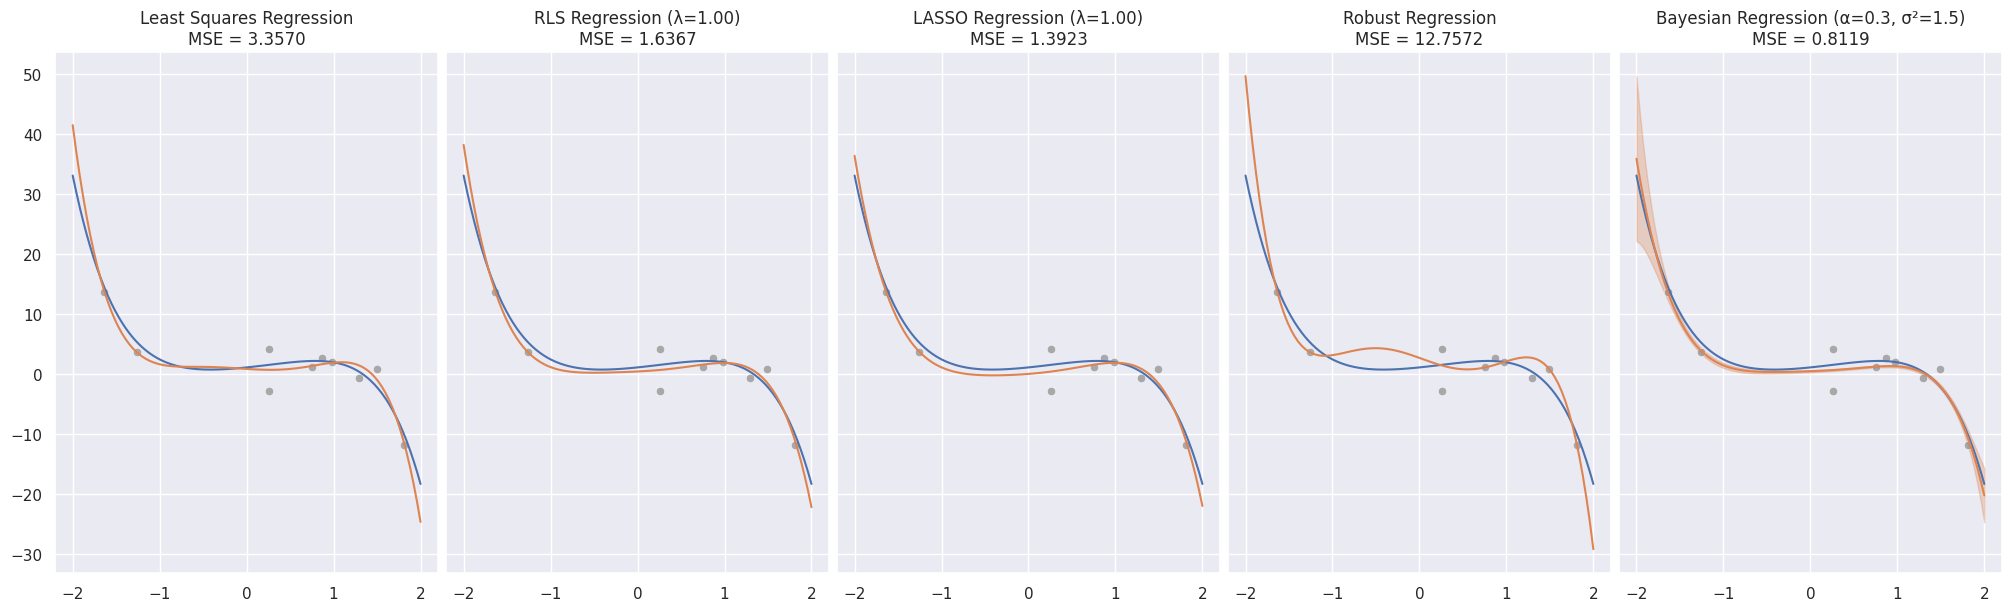

In [12]:
def fit_predict_plot_reduced_data(models, phi=poly_5, training_size=1, seed=12):
    n = y_sample.size
    rng = np.random.default_rng(seed)
    rand_idx = rng.permutation(n)[:math.ceil(n * training_size)]
    X_sample_subset = X_sample[:, rand_idx]
    y_sample_subset = y_sample[rand_idx]

    _, axs = plt.subplots(1, len(models), sharey=True, figsize=(len(models) * 4, 6), constrained_layout=True)

    for model, ax in zip(models, axs):
        model.phi = phi
        result = model.fit(X_sample_subset, y_sample_subset)
        y_poly_predict, std = model.predict(X_poly)
        mse = np.square(y_poly - y_poly_predict).mean()

        print(model.title)
        print(f"Estimated parameter:\n{result}")
        print(f"Mean squared error: {mse}")
        print("-" * 72)

        X_poly_1d = X_poly.reshape((-1,))
        colors = sns.color_palette()

        # test dataset
        sns.lineplot(x=X_poly_1d, y=y_poly, color=colors[0], ax=ax)
        sns.lineplot(x=X_poly_1d, y=y_poly_predict, color=colors[1], ax=ax)
        if std is not None:
            ax.fill_between(X_poly_1d, y_poly_predict - std, y_poly_predict + std, color=colors[1], alpha=0.3)

        # sample dataset
        sns.scatterplot(x=X_sample_subset.reshape((-1,)), y=y_sample_subset, alpha=0.7, color=colors[7], ax=ax)

        ax.set_title(f"{model.title}\nMSE = {mse:.4f}")

models_1c = [LS(), RLS(l=1), LASSO(l=1), RR(), BR(alpha=0.3, sigma_2=1.5)]
fit_predict_plot_reduced_data(models_1c, training_size=0.2, seed=45)

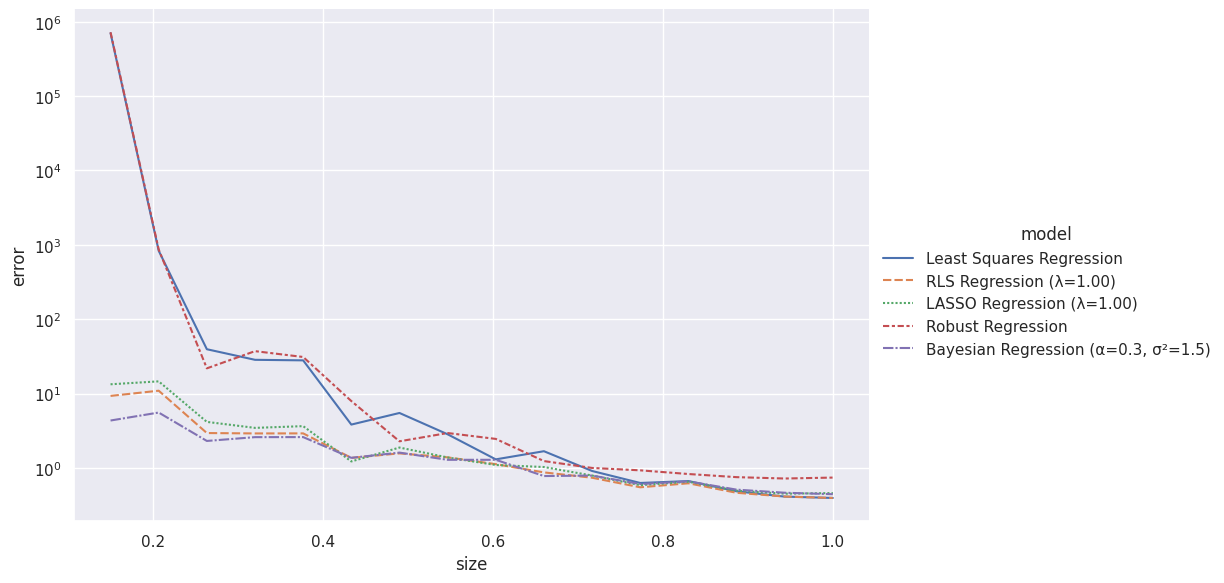

In [13]:
def error_vs_training_size(models, phi=poly_5, num_sizes=10, num_samples=5, seed=12):
    n = y_sample.size
    sizes = np.linspace(0.15, 1, num=num_sizes)
    rng = np.random.default_rng(seed)
    seeds = rng.integers(10*num_sizes*num_samples, size=(num_sizes, num_samples))

    def sample_mses(models, subset_size, seed):
        rng = np.random.default_rng(seed)
        rand_idx = rng.permutation(n)[:subset_size]
        X_sample_subset = X_sample[:, rand_idx]
        y_sample_subset = y_sample[rand_idx]

        mses = []
        for model in models:
            model.phi = phi
            result = model.fit(X_sample_subset, y_sample_subset)
            y_poly_predict, _ = model.predict(X_poly)
            mse = np.square(y_poly - y_poly_predict).mean()

            mses.append(mse)
        return mses

    # row 1: size, row 2: errors, row 3: model
    data = np.empty((3, 0))
    for i, size in np.ndenumerate(sizes):
        subset_size = int(n * size) + 1
        # average MSE of each model at training_size=size based on multiple samples
        errors = np.zeros((1, len(models)))
        for run in range(num_samples):
            mses = sample_mses(models, subset_size, seeds[i[0], run])
            errors = np.vstack((errors, mses))
        mean_mses = errors.mean(axis=0)
        sample_result = np.vstack((
            np.full_like(mean_mses, size),
            mean_mses,
            np.arange(len(models)),
        ))
        data = np.hstack((data, sample_result))

    titles = np.array([model.title for model in models])
    df = pd.DataFrame({
        "size": data[0, :],
        "error": data[1, :],
        "model": titles[data[2, :].astype(int)],
    })

    g = sns.relplot(
        data=df,
        x="size",
        y="error",
        hue="model",
        style="model",
        kind="line",
        height=6,
        aspect=1.6,
    )
    g.set(yscale="log")

error_vs_training_size(models_1c, num_sizes=16, num_samples=30, seed=123)

In the above experiment, for each specific training subset size, e.g., 0.5, we select a random subset of the training data of that size then fit the regression models to it for 50 times, then take the average mean squared error (MSE). In the end, we get a plot like above, where `size` indicates the proportion of the selected training data, and `error` is the average MSE of each model after repeat 50 times.

We see that when the amount of data is very low, i.e., around 30% smaller than the original training set, the best performing model is undoubtedly Bayesian regression, followed by RLS and LASSO regression, while least squares and robust regression performs very badly due to overfitting. When there are a decent amount of data, then all methods except robust regression perform equally well, with robust regression falling behind when the subset approaches the full original training data. Overall, the most robust method seems to be Bayesian regression.

### (d) Outliers robustness

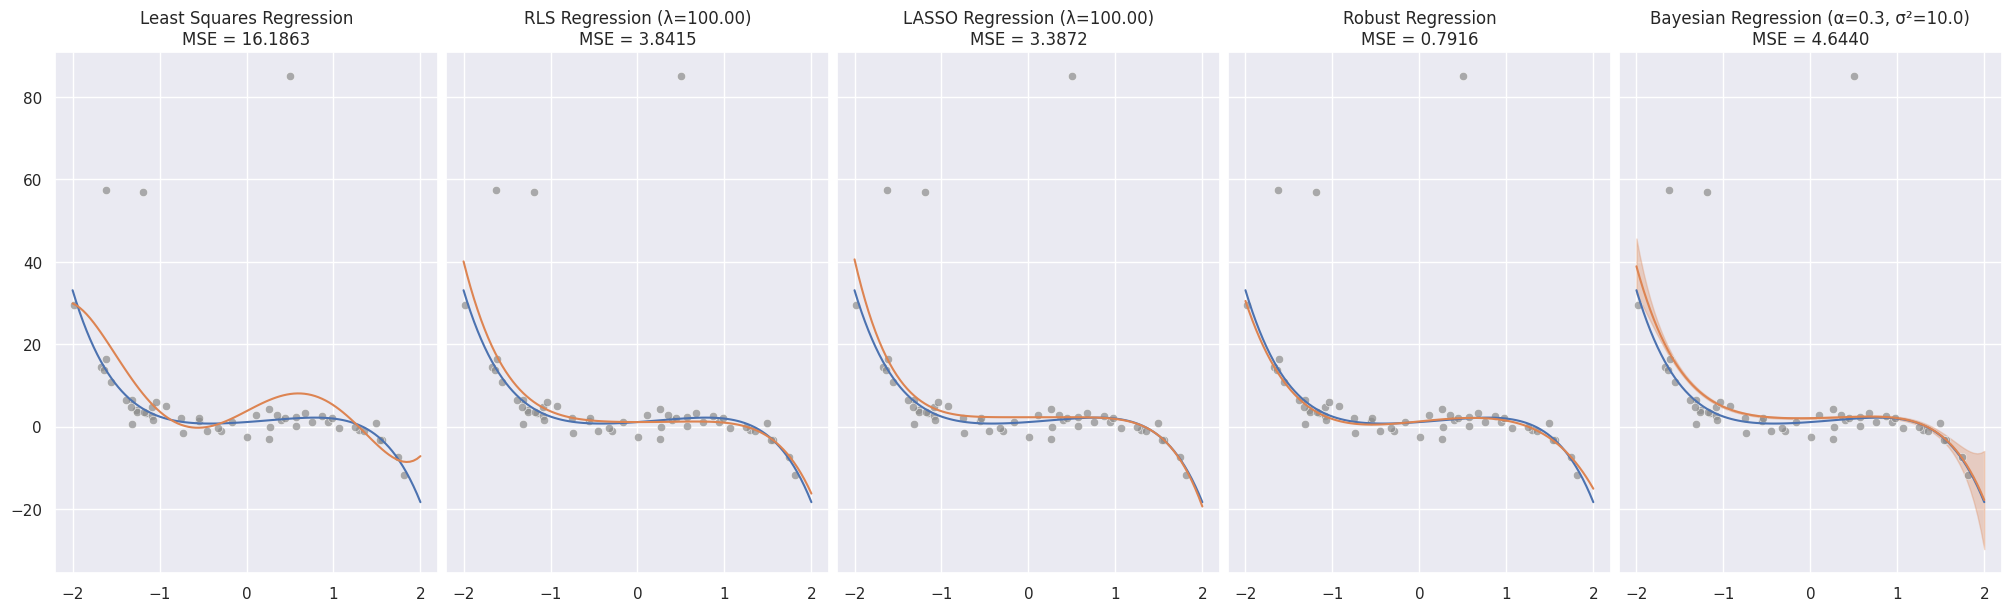

In [14]:
def fit_predict_plot_outliers(models, phi=poly_5, num_outliers=3, seed=12):
    rng = np.random.default_rng(seed)
    upper = abs(np.max(y_sample))
    qs = np.sort(rng.random(size=num_outliers))

    X_outlier = np.quantile(X_sample, qs, axis=1).T
    y_outlier = rng.uniform(low=1.5*upper+5, high=3*upper + 5, size=num_outliers)
    X_sample_outlier = np.hstack((X_sample, X_outlier))
    y_sample_outlier = np.hstack((y_sample, y_outlier))

    fig, axs = plt.subplots(1, len(models), figsize=(len(models) * 4, 6), sharey=True, constrained_layout=True)

    for model, ax in zip(models, axs):
        model.phi = phi
        result = model.fit(X_sample_outlier, y_sample_outlier)
        y_poly_predict, std = model.predict(X_poly)
        mse = np.square(y_poly - y_poly_predict).mean()

        X_poly_1d = X_poly.reshape((-1,))
        colors = sns.color_palette()

        # test dataset
        sns.lineplot(x=X_poly_1d, y=y_poly, color=colors[0], ax=ax)
        sns.lineplot(x=X_poly_1d, y=y_poly_predict, color=colors[1], ax=ax)
        if std is not None:
            ax.fill_between(X_poly_1d, y_poly_predict - std, y_poly_predict + std, color=colors[1], alpha=0.3)

        # sample dataset
        sns.scatterplot(x=X_sample_outlier.reshape((-1,)), y=y_sample_outlier, alpha=0.7, color=colors[7], ax=ax)

        ax.set_title(f"{model.title}\nMSE = {mse:.4f}")

models_1d = [LS(), RLS(l=100), LASSO(l=100), RR(), BR(alpha=0.3, sigma_2=10)]
fit_predict_plot_outliers(models_1d, num_outliers=3, seed=123)

In the presence of outliers, robust regression is the best method, with outliers bearing virtually no negative impact on its accuracy and precision. In my opinion, this is because robust regression optimizes the $L^1$-norm of the error, which is less sensitive to outliers compared to the standard $L^2$-norm (alternatively, the statistics that minimizes the $L^1$-norm is the median, which is less affected by the tail of the distribution). RLS, LASSO, and Bayesian regression are also somewhat capable of handling the case of outliers by tweaking their hyperparameters, specifically by
- choosing a large lambda to penalize the complexity of the estimator in the case of RLS and LASSO, and
- choosing a large sample variance to signify a higher possibility of outliers in the case of Bayesian regression.

Here, least squares regression performs the worst and is easily affected by outliers, even with just one of them, due to it optimizing the $L_2$-norm, which overemphasizes outliers by squaring them, and inability to regulate its behavior through the use of penalty terms or prior beliefs.

### (e) Complex model

Least Squares Regression
[ -0.0993758    3.79351203   6.49122012 -10.74477383  -5.52167701
   8.63226351   0.6537136   -3.04579888   0.76354946   0.31028117
  -0.17513791]
------------------------------------------------------------------------
RLS Regression (λ=3.00)
[ 0.84208891  0.32357596  0.78369772 -0.40735401 -0.0073885  -0.29183431
 -0.29336061 -0.14217197  0.34445196 -0.00102968 -0.07224856]
------------------------------------------------------------------------
LASSO Regression (λ=0.50)
[ 5.20181208e-01  9.99149184e-01  2.65111278e+00 -1.52834537e+00
 -8.53522556e-01 -1.67747587e-05 -1.29899149e+00  7.02514618e-03
  1.05514836e+00 -5.05913704e-02 -1.85751165e-01]
------------------------------------------------------------------------
Robust Regression
[ -0.77214121   3.0252024   13.14885338  -7.57592575 -19.78002561
   5.64238377  12.19446275  -2.16419757  -3.15723807   0.24538581
   0.29052235]
------------------------------------------------------------------------
Bayesi

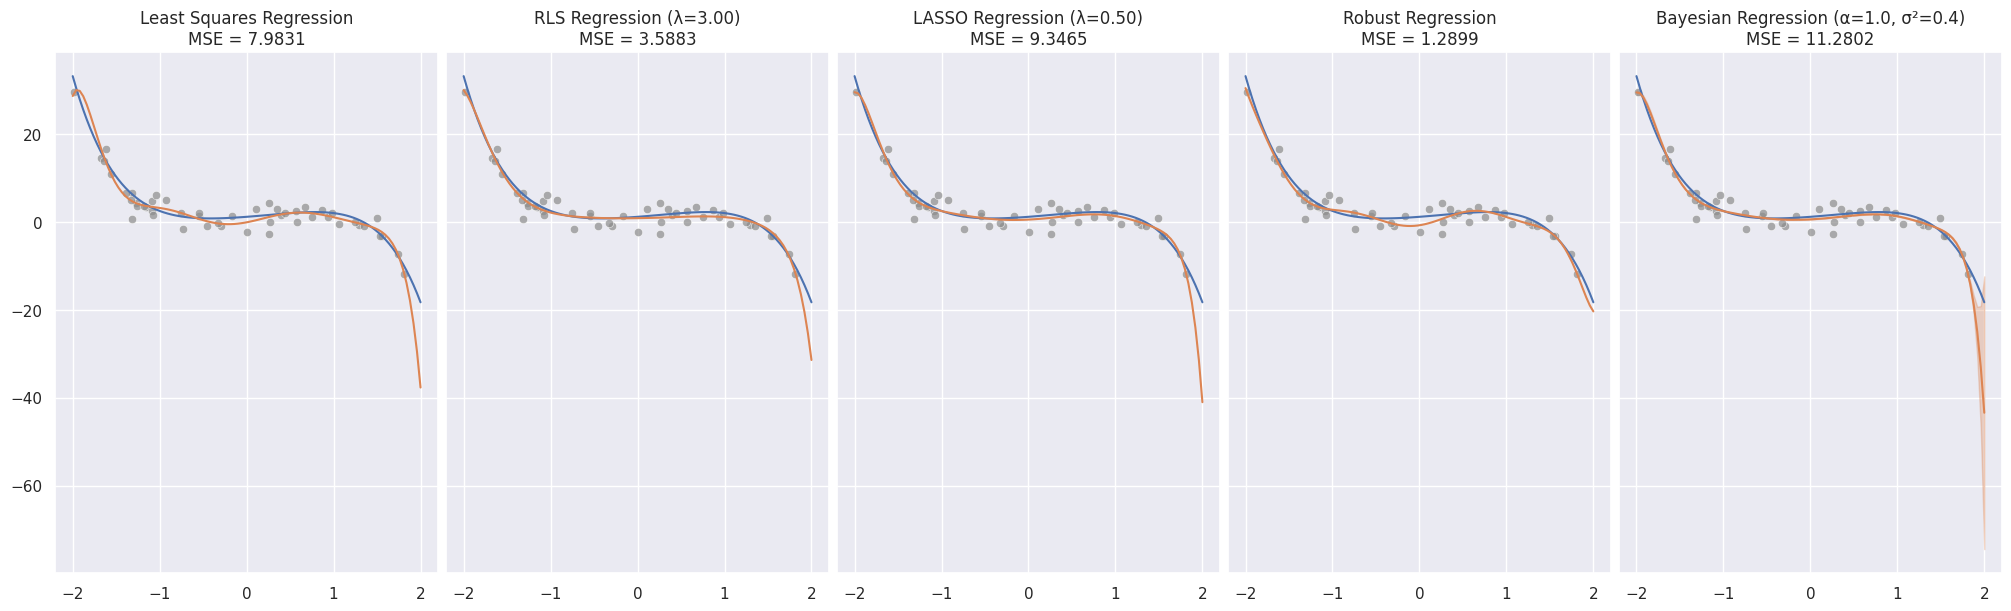

In [15]:
def fit_predict_plot_poly_10(models):
    poly_10 = lambda x: x[0]**np.array(range(10+1))

    fig, axs = plt.subplots(1, len(models), figsize=(len(models) * 4, 6), sharey=True, constrained_layout=True)

    for model, ax in zip(models, axs):
        model.phi = poly_10
        result = model.fit(X_sample, y_sample)
        y_poly_predict, std = model.predict(X_poly)
        mse = np.square(y_poly - y_poly_predict).mean()

        print(model.title)
        print(result)
        print("-" * 72)

        X_poly_1d = X_poly.reshape((-1,))
        colors = sns.color_palette()

        # test dataset
        sns.lineplot(x=X_poly_1d, y=y_poly, color=colors[0], ax=ax)
        sns.lineplot(x=X_poly_1d, y=y_poly_predict, color=colors[1], ax=ax)
        if std is not None:
            ax.fill_between(X_poly_1d, y_poly_predict - std, y_poly_predict + std, color=colors[1], alpha=0.3)

        # sample dataset
        sns.scatterplot(x=X_sample.reshape((-1,)), y=y_sample, alpha=0.7, color=colors[7], ax=ax)

        ax.set_title(f"{model.title}\nMSE = {mse:.4f}")

models_1e = [LS(), RLS(l=3), LASSO(l=0.5), RR(), BR(alpha=1, sigma_2=0.4)]
fit_predict_plot_poly_10(models_1e)

From the graph, we can see that least squares and robust regression exhibit the highest degree of overfitting a complex model to the data, with their prediction curved strangely to the training data. Bayesian regression also suffers somewhat from this problem, while LASSO and RLS regression are the most resistant to overfitting. Examining the estimated parameters corroborates our belief: RLS, LASSO, and Bayesian regression parameters are mostly in the normal range of $[-2,2]$, while the parameters predicted by least squares and robust regression have much larger magnitudes (exceeding 5 or even 10), a sign of overfitting in play.

## Part 2: Counting people

In [37]:
count_path = "PA-1-data-text/count_data_"
y_mean = read_input(f"{count_path}ym.txt")
X_train = read_input(f"{count_path}trainx.txt", atleast_2d=True)
y_train = read_input(f"{count_path}trainy.txt")
X_test = read_input(f"{count_path}testx.txt", atleast_2d=True)
y_test = read_input(f"{count_path}testy.txt")

We can first try to plot the training data to see if there is visible relationship. Since we have 9 features, it is difficult to comprehensively visualize the datatset in one single plot, so we will plot each feature against the people count. Here, we can say roughly that the dependent $y$ is most strongly positively correlated with $x_0$ and $x_1$, slightly less so with $x_5$ and $x_6$, while being negatively correlated with $x_8$.

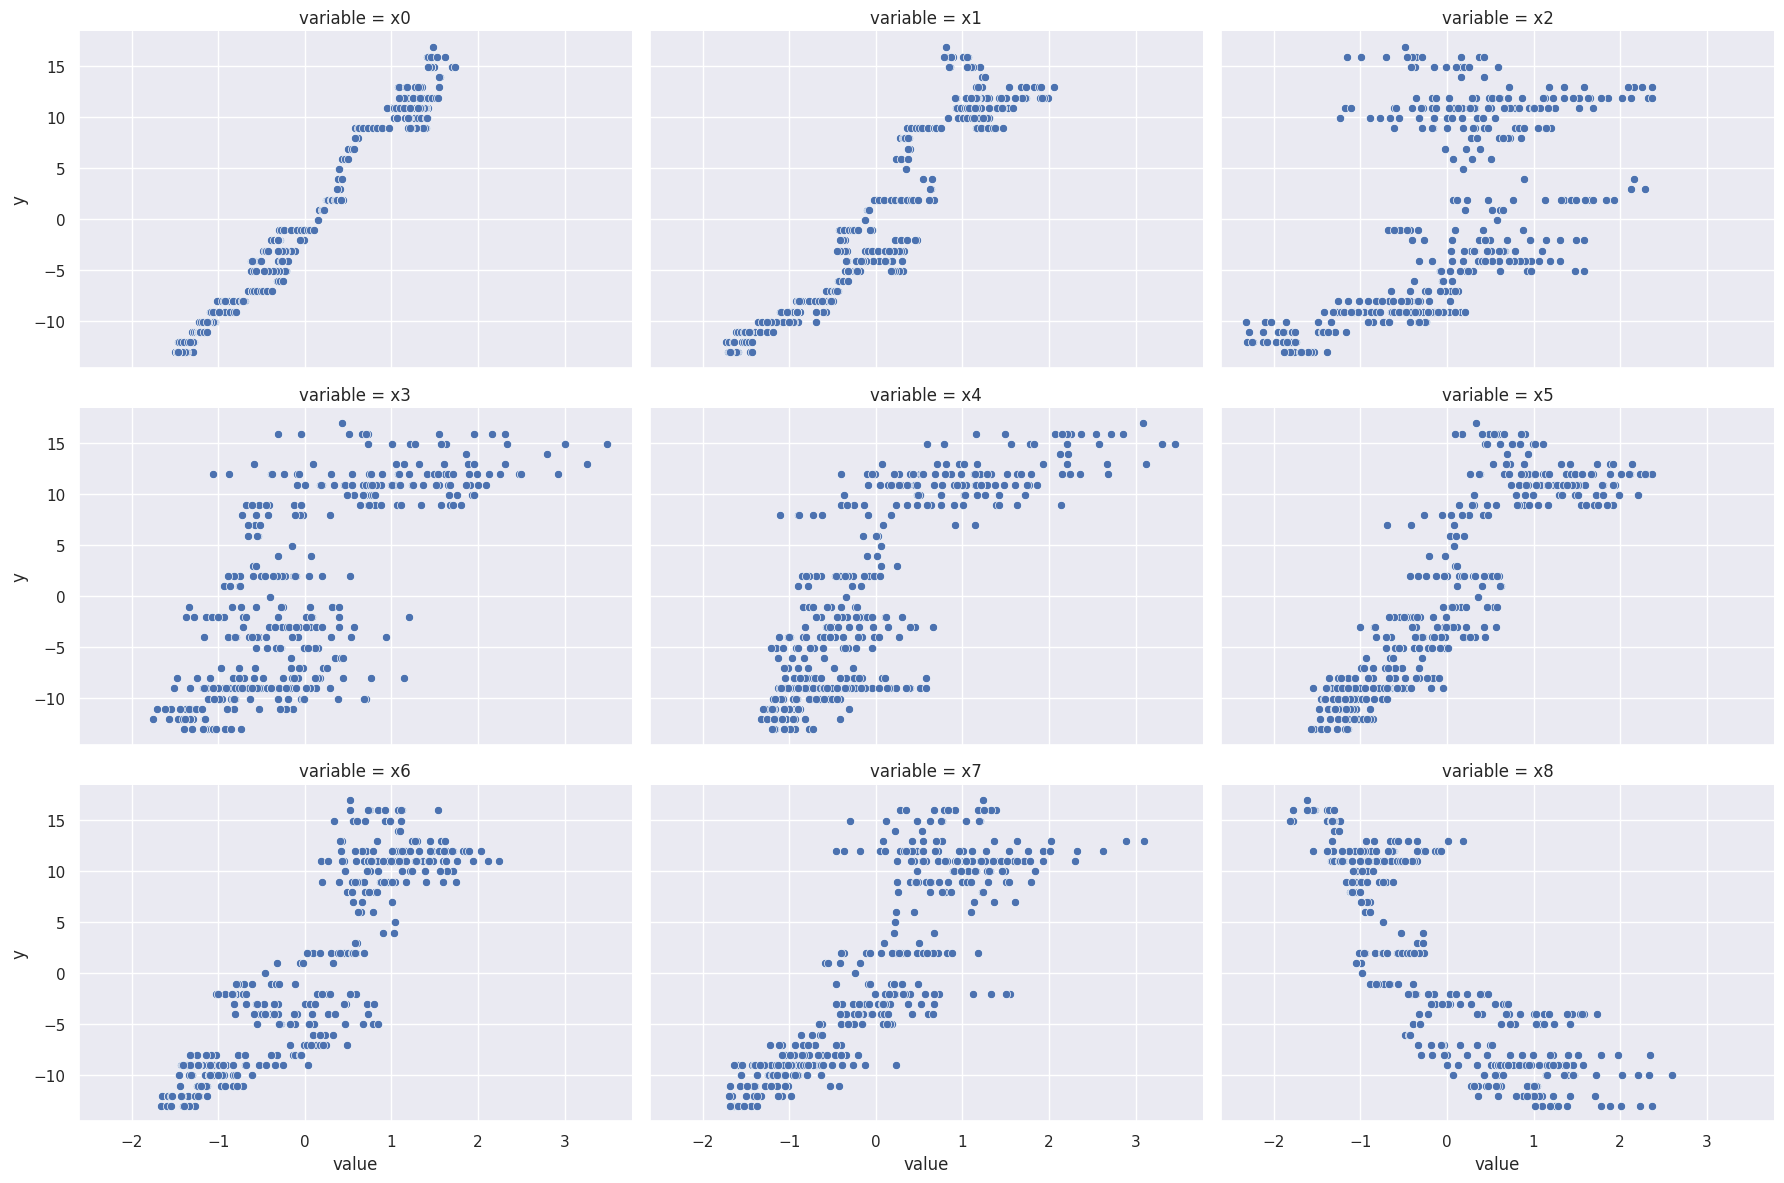

In [17]:
df_Xy = pd.DataFrame(np.column_stack((X_train.T, y_train)), columns=[f"x{i}" for i in range(9)] + ["y"])
df_Xy = df_Xy.melt(id_vars=["y"])
sns.relplot(df_Xy, x="value", y="y", col="variable", col_wrap=3, height=4, aspect=1.5)

Least Squares Regression
Mean absolute error: 1.3250
Mean squared error: 3.1450
----------------------------------------
RLS Regression (λ=0.50)
Mean absolute error: 1.2617
Mean squared error: 2.7417
----------------------------------------
LASSO Regression (λ=5.00)
Mean absolute error: 1.2233
Mean squared error: 2.4900
----------------------------------------
Robust Regression
Mean absolute error: 1.3350
Mean squared error: 3.1783
----------------------------------------
Bayesian Regression (α=1.5, σ²=1.2)
Mean absolute error: 1.2600
Mean squared error: 2.7133
----------------------------------------


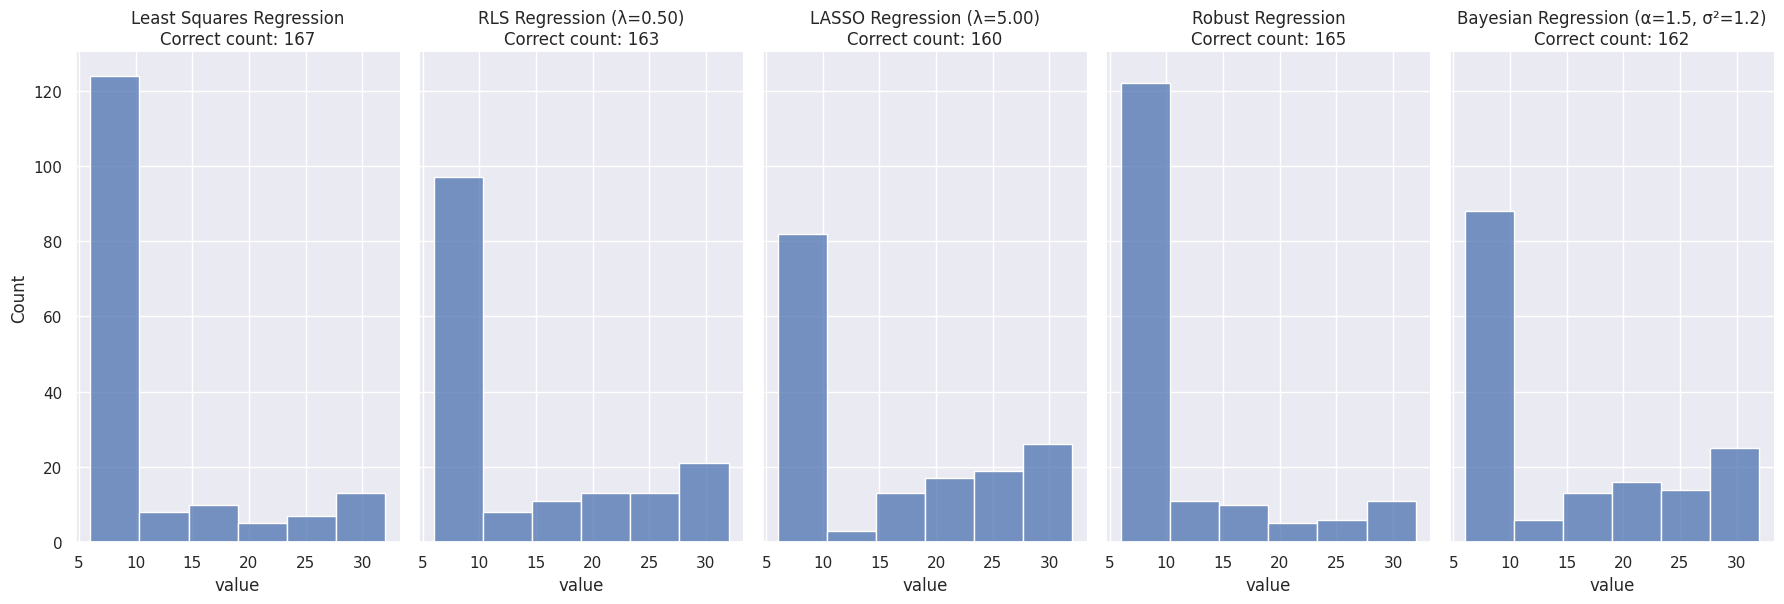

In [16]:
def fit_predict_plot_count(models, phi):
    df = pd.DataFrame()
    correct_counts = []
    for model in models:
        model.phi = phi
        result = model.fit(X_train, y_train)
        y_test_predict, std = model.predict(X_test)

        y_test_int = y_test + y_mean
        y_test_predict_int = np.round(y_test_predict + y_mean)

        mae = np.abs(y_test_int - y_test_predict_int).mean()
        mse = np.square(y_test_int - y_test_predict_int).mean()
        print(model.title)
        print(f"Mean absolute error: {mae:.4f}")
        print(f"Mean squared error: {mse:.4f}")
        #print(f"Estimated parameter:\n{result}")
        print("-" * 40)

        correct_predicts = y_test_int[np.abs(y_test_int - y_test_predict_int) <= 0]
        correct_counts.append(correct_predicts.size)
        df_correct_predict = pd.DataFrame({
            "value": correct_predicts,
            "model": [model.title] * correct_predicts.size,
        })
        df = pd.concat([df, df_correct_predict], axis=0)

    g = sns.displot(df, x="value", binwidth=4, col="model", height=6, aspect=0.6)
    for ax, model, count in zip(g.axes[0], models, correct_counts):
        ax.set_title(f"{model.title}\nCorrect count: {count}")

models_2a = [LS(), RLS(l=0.5), LASSO(l=5), RR(), BR(alpha=1.5, sigma_2=1.2)]
fit_predict_plot_count(models_2a, phi=lambda x: x)

### 2(b) Alternative feature transformation

Least Squares Regression
Mean absolute error: 1.3083
Mean squared error: 3.0017
----------------------------------------
RLS Regression (λ=0.50)
Mean absolute error: 1.1767
Mean squared error: 2.4500
----------------------------------------
LASSO Regression (λ=5.00)
Mean absolute error: 1.1383
Mean squared error: 2.4183
----------------------------------------
Robust Regression
Mean absolute error: 1.3000
Mean squared error: 3.0133
----------------------------------------
Bayesian Regression (α=1.5, σ²=1.2)
Mean absolute error: 1.1833
Mean squared error: 2.5233
----------------------------------------


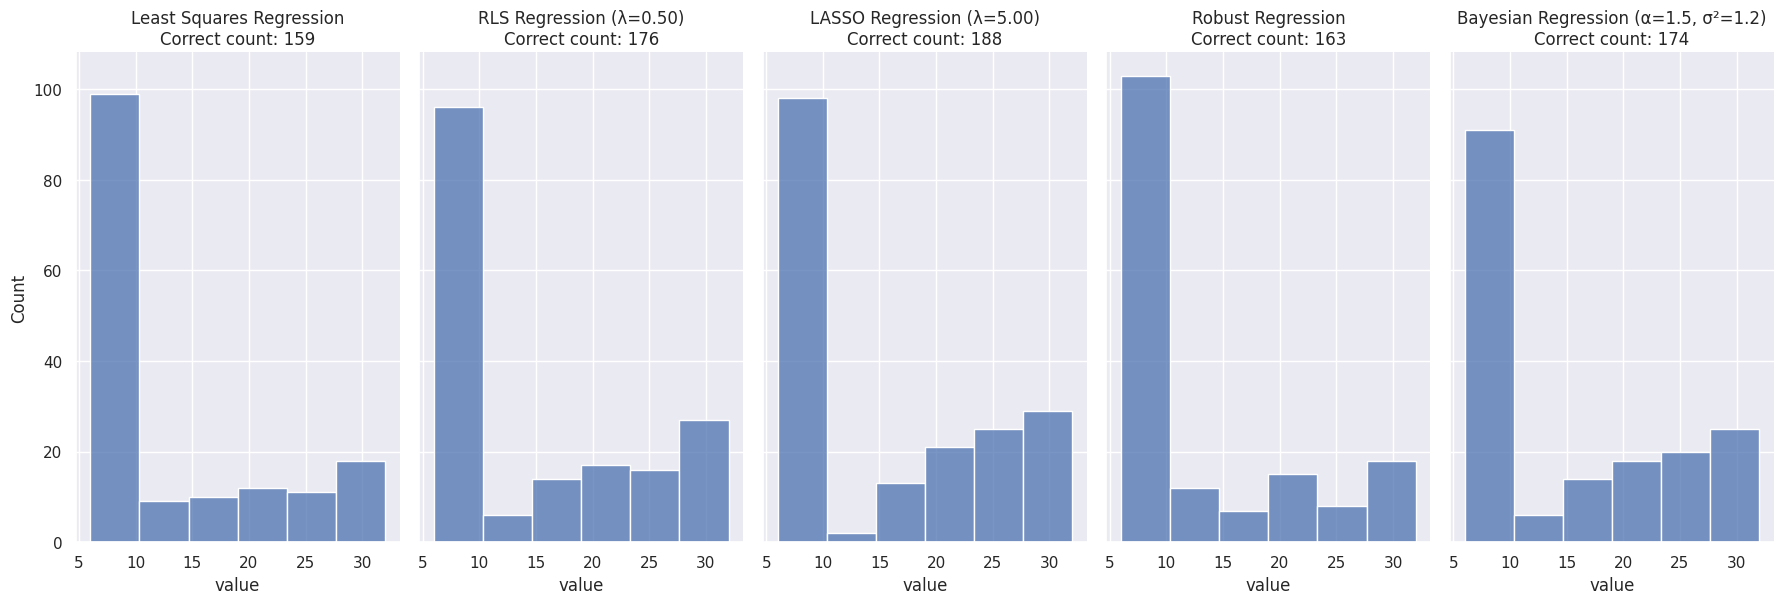

In [19]:
# maps (x1, ..., x9) to (x1, ..., x9, x1^2, ..., x9^2)
poly_2 = lambda x: np.concatenate((x, x**2))
fit_predict_plot_count(models_2a, phi=poly_2)

Least Squares Regression
Mean absolute error: 1.4433
Mean squared error: 3.7500
----------------------------------------
RLS Regression (λ=3.00)
Mean absolute error: 1.1400
Mean squared error: 2.5600
----------------------------------------
LASSO Regression (λ=3.00)
Mean absolute error: 1.1883
Mean squared error: 2.6917
----------------------------------------
Robust Regression
Mean absolute error: 1.4867
Mean squared error: 3.9100
----------------------------------------
Bayesian Regression (α=1.0, σ²=2.5)
Mean absolute error: 1.1567
Mean squared error: 2.6333
----------------------------------------


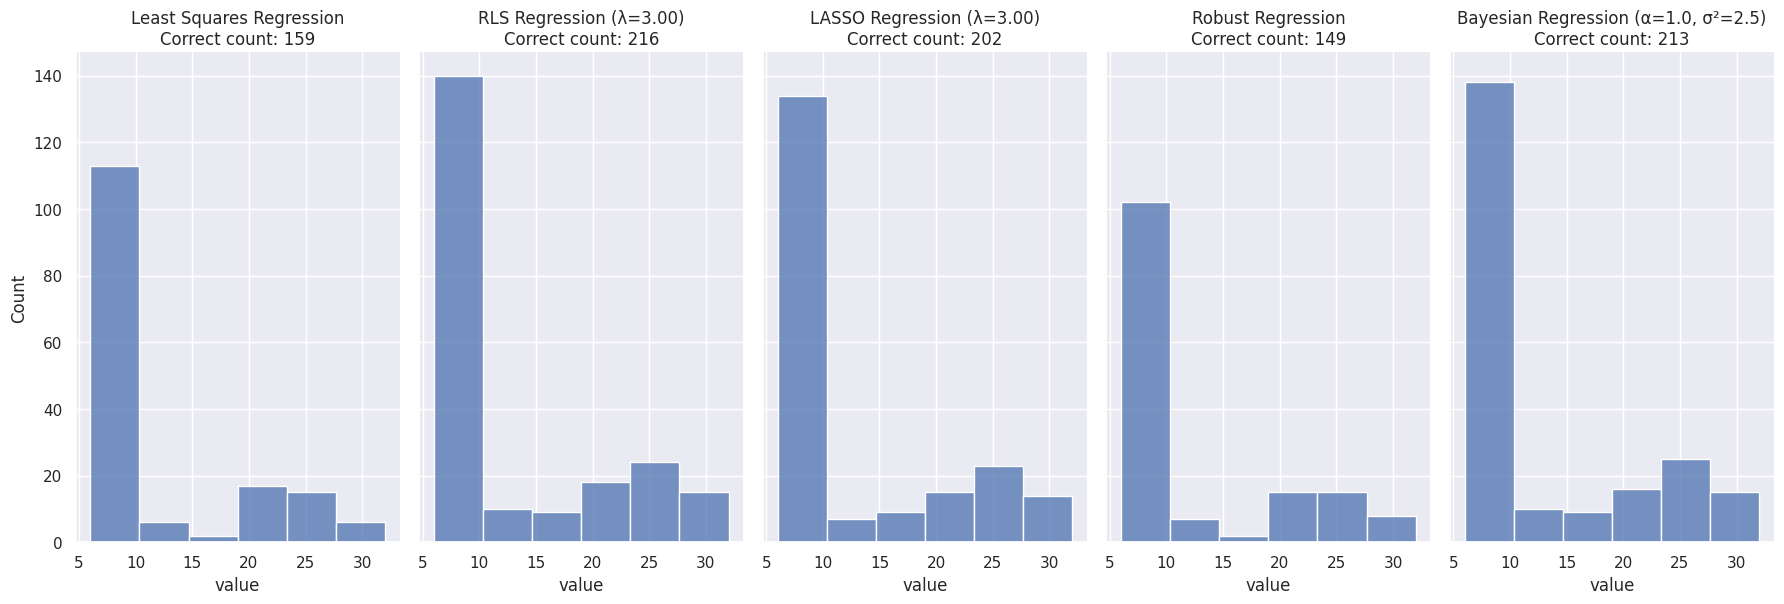

In [58]:
models_2b = [LS(), RLS(l=3), LASSO(l=3), RR(), BR(alpha=1, sigma_2=2.5)]
phi = lambda x: np.concatenate((
    x,
    x**2,
    x**3 / 2,
    x**4 / 24,
    np.exp(x[:1] * x[1:]),
))
fit_predict_plot_count(models_2b, phi=phi)

Least Squares Regression
Mean absolute error: 1.4517
Mean squared error: 3.9183
----------------------------------------
RLS Regression (λ=3.00)
Mean absolute error: 1.4467
Mean squared error: 3.5567
----------------------------------------
LASSO Regression (λ=3.00)
Mean absolute error: 1.3217
Mean squared error: 3.1750
----------------------------------------
Robust Regression
Mean absolute error: 1.4617
Mean squared error: 3.7750
----------------------------------------
Bayesian Regression (α=1.0, σ²=2.5)
Mean absolute error: 1.4467
Mean squared error: 3.5567
----------------------------------------


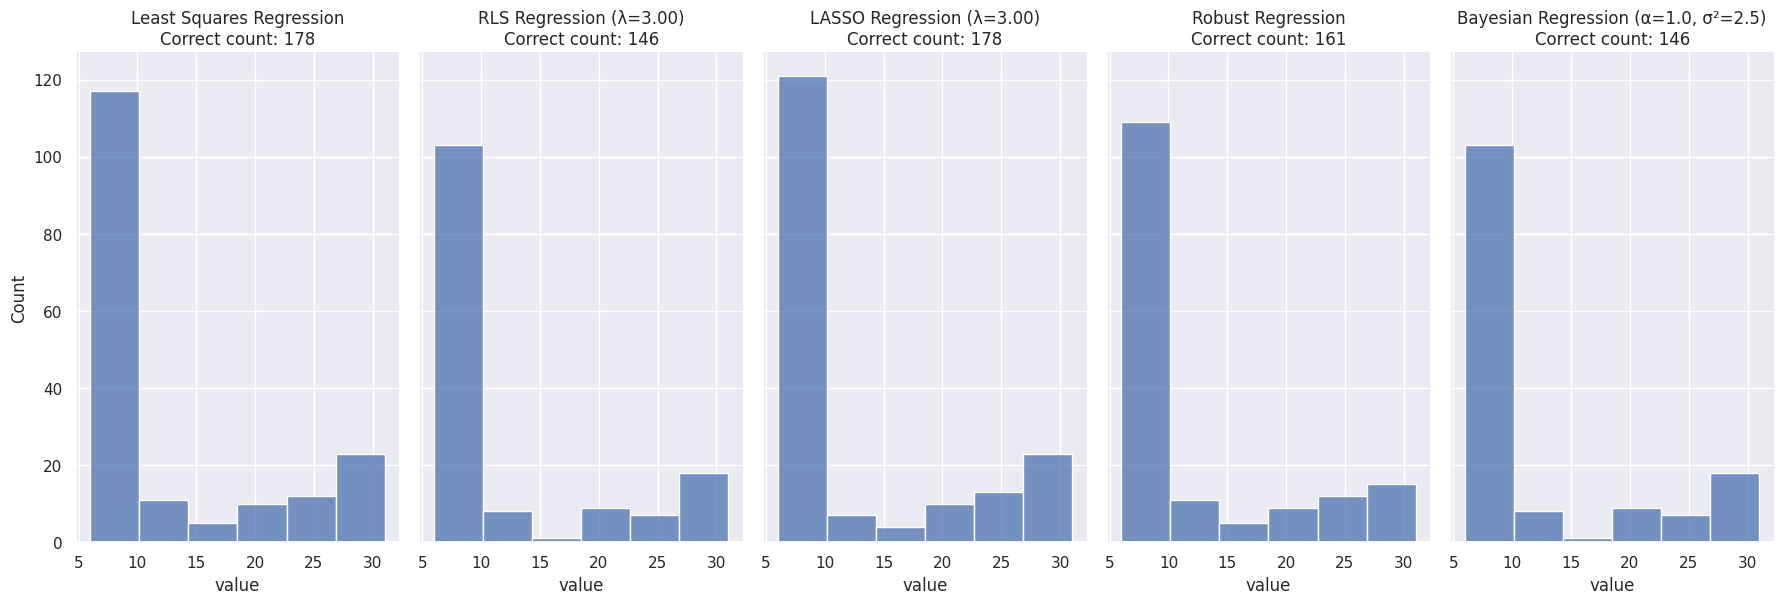

In [91]:
models_2b = [LS(), RLS(l=3), LASSO(l=3), RR(), BR(alpha=1, sigma_2=2.5)]
phi = lambda x: np.concatenate((
    np.log1p(np.sinc(x**3)),
    np.exp(x[:1] * x[1:]),
    np.sin(x),
    x / (1 + x**2),
    np.convolve(x, x**2),
))
fit_predict_plot_count(models_2b, phi=phi)

## Estimating hyperparameters

In [17]:
def fit_predict_2a(model, phi, X_train, y_train, X_test, y_test):
    model.phi = phi
    result = model.fit(X_train, y_train)
    y_test_predict, std = model.predict(X_test)

    y_test_int = y_test + y_mean
    y_test_predict_int = np.round(y_test_predict + y_mean)

    mae = np.abs(y_test_int - y_test_predict_int).mean()
    mse = np.square(y_test_int - y_test_predict_int).mean()
    correct_predicts = y_test_int[y_test_int == y_test_predict_int]

    return (mae, mse, correct_predicts.size)

In [120]:
def cross_validation(models, phi, X, y, k=5, seed=12):
    n = y.size
    indices = np.arange(n)

    rng = np.random.default_rng(seed)
    rng.shuffle(indices)
    fold_size = n // k

    results = []

    for i in range(k):
        test_indices = indices[i*fold_size:(i+1)*fold_size]
        train_indices = np.concatenate((indices[:i*fold_size], indices[(i+1)*fold_size:]))
        X_train, X_test = X[:, train_indices], X[:, test_indices]
        y_train, y_test = y[train_indices], y[test_indices]

        for model in models:
            mae, mse, correct_count = fit_predict_2a(model, phi, X_train, y_train, X_test, y_test)
            results.append((i, model.hyperparam(), mae, mse, correct_count))

    df = pd.DataFrame(results, columns=["iter", "model", "mae", "mse", "correct_count"])
    return df

def estimate_hyperparam_kfold(models, phi, k=5, seed=12):
    df = cross_validation(models, phi, X_train, y_train, k=k, seed=seed)
    mse = df.groupby("model", sort=False)["mse"].mean().reset_index()["mse"].to_numpy()
    mae = df.groupby("model", sort=False)["mae"].mean().reset_index()["mae"].to_numpy()
    correct_count = df.groupby("model", sort=False)["correct_count"].mean().reset_index()["correct_count"].to_numpy()

    hyperparams = [model.hyperparam() for model in models]
    if not isinstance(hyperparams[0], tuple):
        fig, axs = plt.subplots(3, 1, figsize=(20, 15), sharex=True)
        axs[2].xaxis.set_ticks(np.arange(0, 10.1, 0.5))
        sns.lineplot(x=hyperparams, y=mse, ax=axs[0]).set_title("Mean squared error")
        sns.lineplot(x=hyperparams, y=mae, ax=axs[1]).set_title("Mean absolute error")
        sns.lineplot(x=hyperparams, y=correct_count, ax=axs[2]).set_title("Correct count")
        axs[2].set_xlabel("λ")
    else:
        alpha = [hp[0] for hp in hyperparams]
        sigma_2 = [hp[1] for hp in hyperparams]
        fig, axs = plt.subplots(1, 3, figsize=(20, 6), sharey=True)
        sns.scatterplot(x=alpha, y=sigma_2, hue=mse, ax=axs[0], legend=False).set_title("Mean squared error")
        sns.scatterplot(x=alpha, y=sigma_2, hue=mae, ax=axs[1], legend=False).set_title("Mean absolute error")
        sns.scatterplot(x=alpha, y=sigma_2, hue=correct_count, ax=axs[2], legend=False).set_title("Correct count")
        axs[0].set_ylabel("σ²")
        for ax in axs:
            ax.set_xlabel("α")

    indices = np.argwhere(correct_count == np.max(correct_count)).flatten()
    if indices.size > 1:
        indices = indices[np.argwhere(mae[indices] == np.min(mae[indices]))].flatten()
    if indices.size > 1:
        indices = indices[np.argwhere(mse[indices] == np.max(mse[indices]))].flatten()

    best_model = models[indices[0]]
    print(f"Best model: {best_model.title}")
    return best_model

In [123]:
phi = lambda x: np.concatenate((
    x, x**2, x**3 / 2, x**4 / 24,
    np.exp(x[:1] * x[1:])
))

Best model: RLS Regression (λ=0.10)


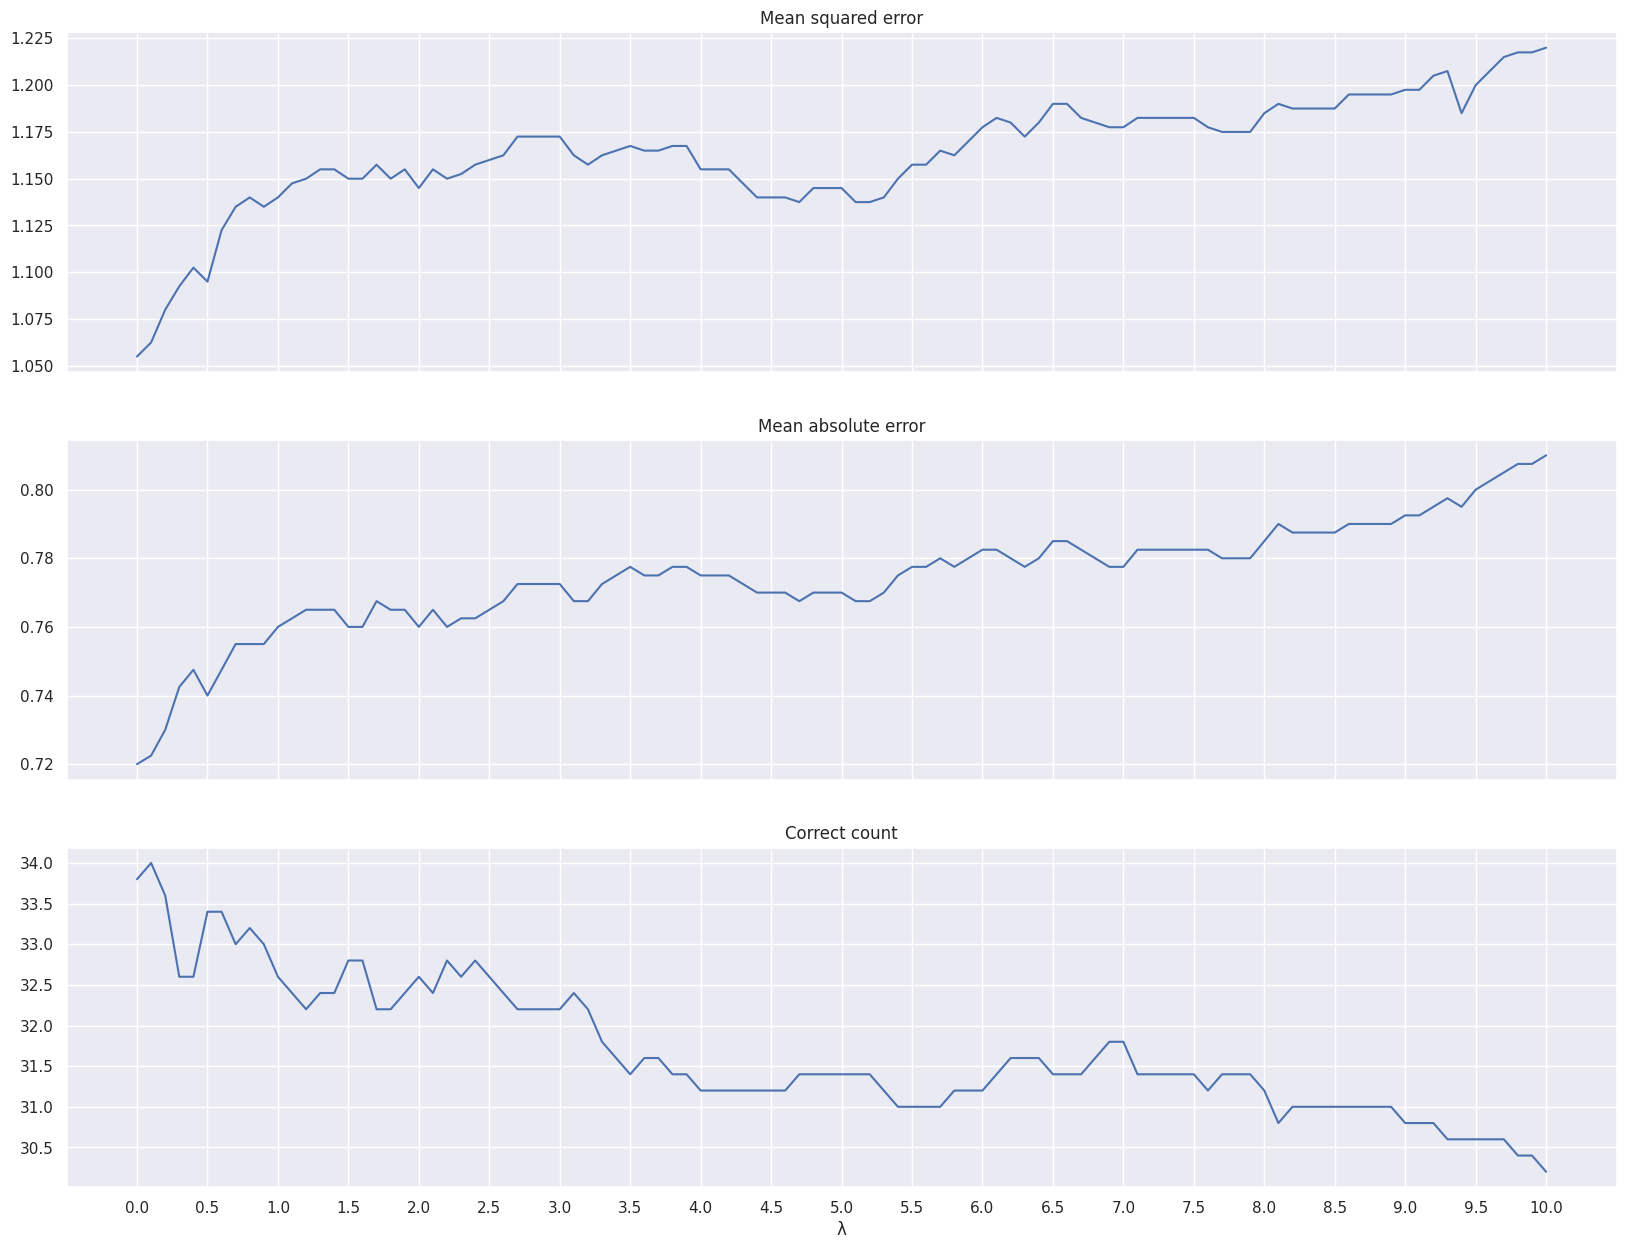

In [124]:
rls_models = [RLS(l) for l in np.arange(0, 10.1, 0.1)]
best_rls = estimate_hyperparam_kfold(rls_models, phi=phi, k=5)

Best model: LASSO Regression (λ=0.40)


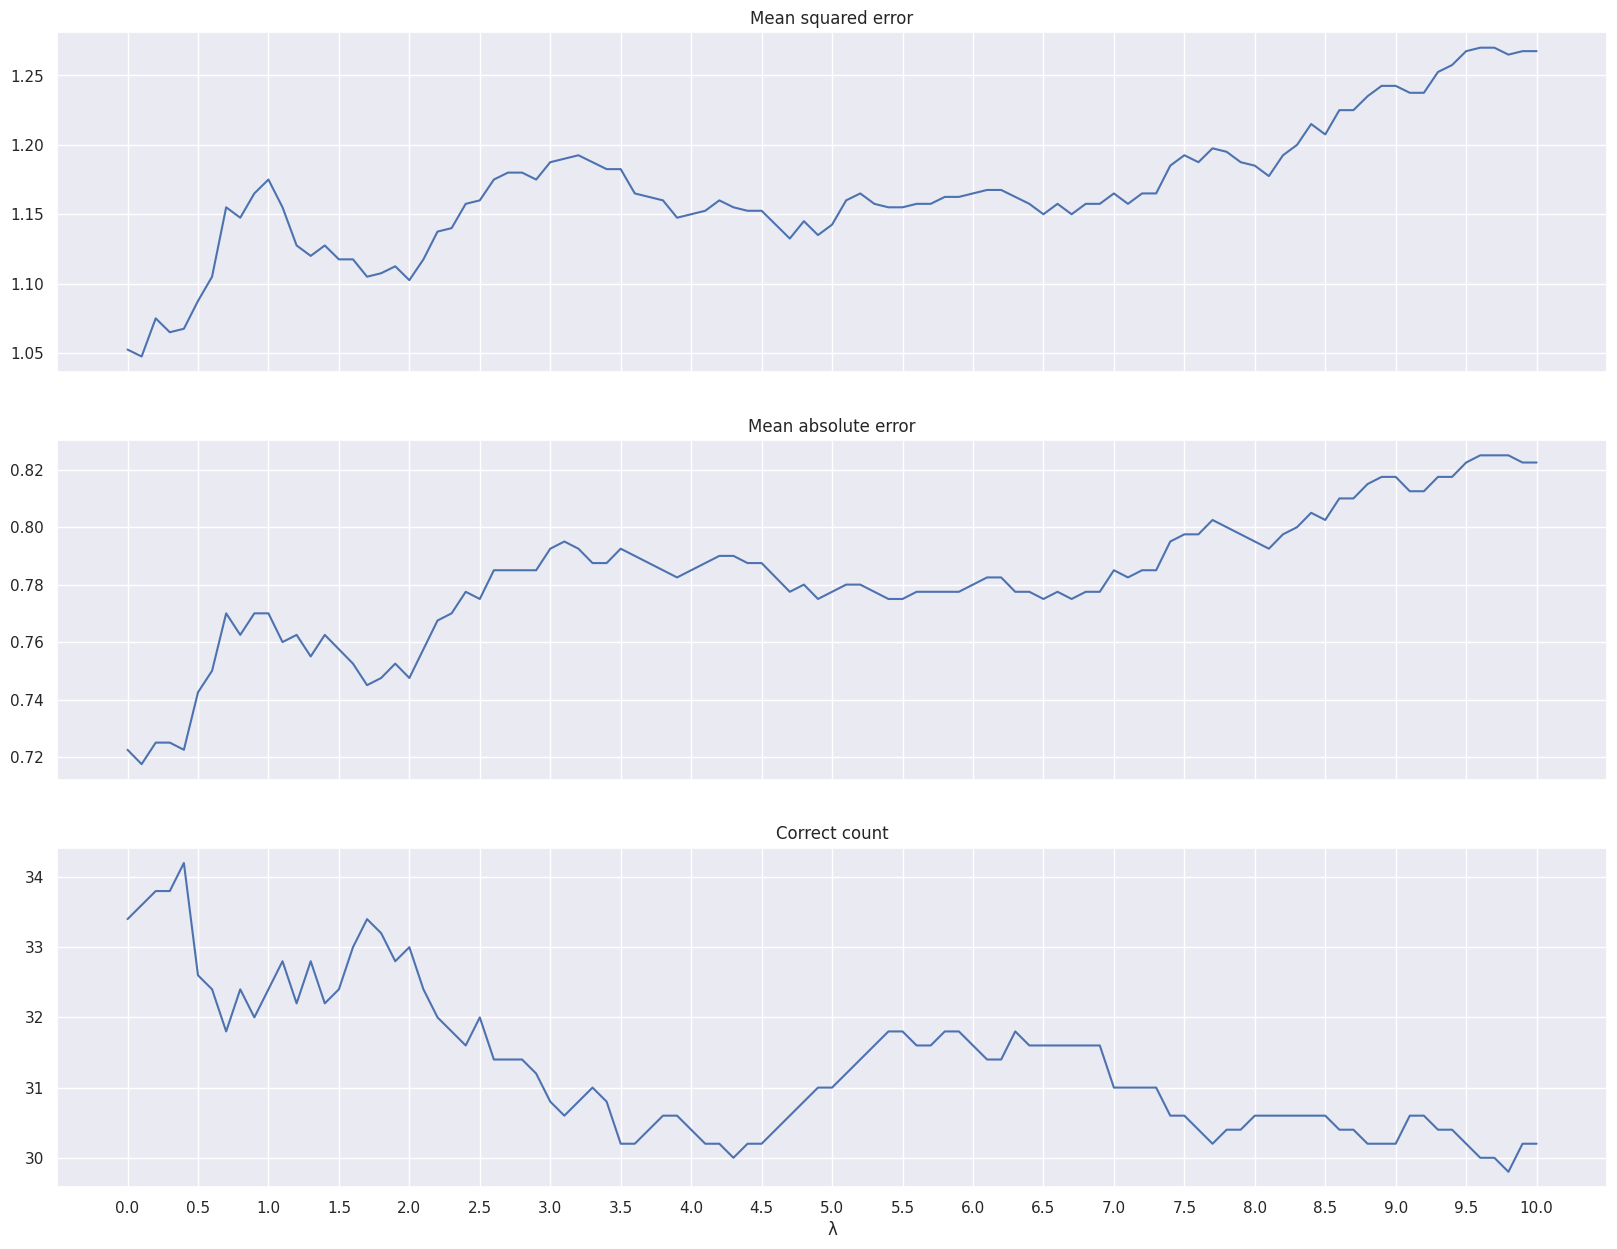

In [125]:
lasso_models = [LASSO(l) for l in np.arange(0, 10.1, 0.1)]
best_lasso = estimate_hyperparam_kfold(lasso_models, phi=phi, k=5)

Best model: Bayesian Regression (α=1.0, σ²=0.1)


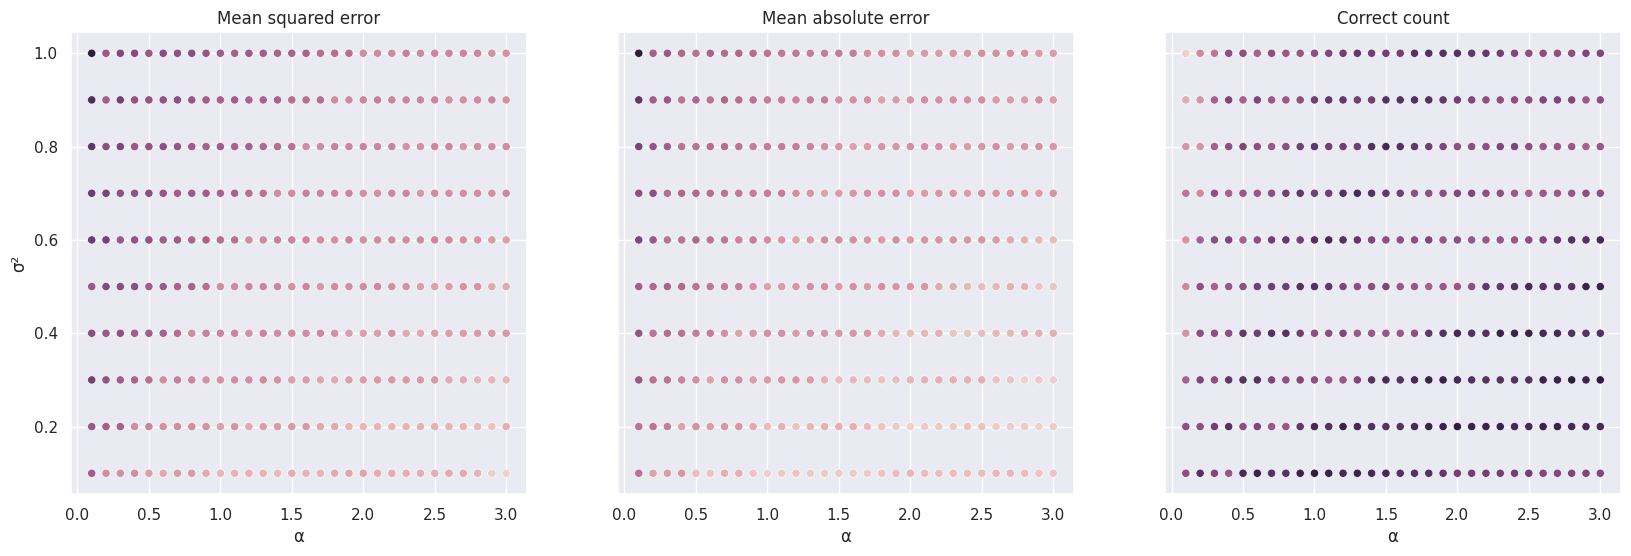

In [126]:
bayes_models = [BR(alpha, sigma_2) for alpha in np.arange(0.1, 3.1, 0.1) for sigma_2 in np.arange(0.1, 1.1, 0.1)]
best_bayes = estimate_hyperparam_kfold(bayes_models, phi=phi, k=5)

RLS Regression (λ=0.10)
Mean absolute error: 1.3617
Mean squared error: 3.4550
----------------------------------------
LASSO Regression (λ=0.40)
Mean absolute error: 1.3067
Mean squared error: 3.2767
----------------------------------------
Bayesian Regression (α=1.0, σ²=0.1)
Mean absolute error: 1.3617
Mean squared error: 3.4550
----------------------------------------


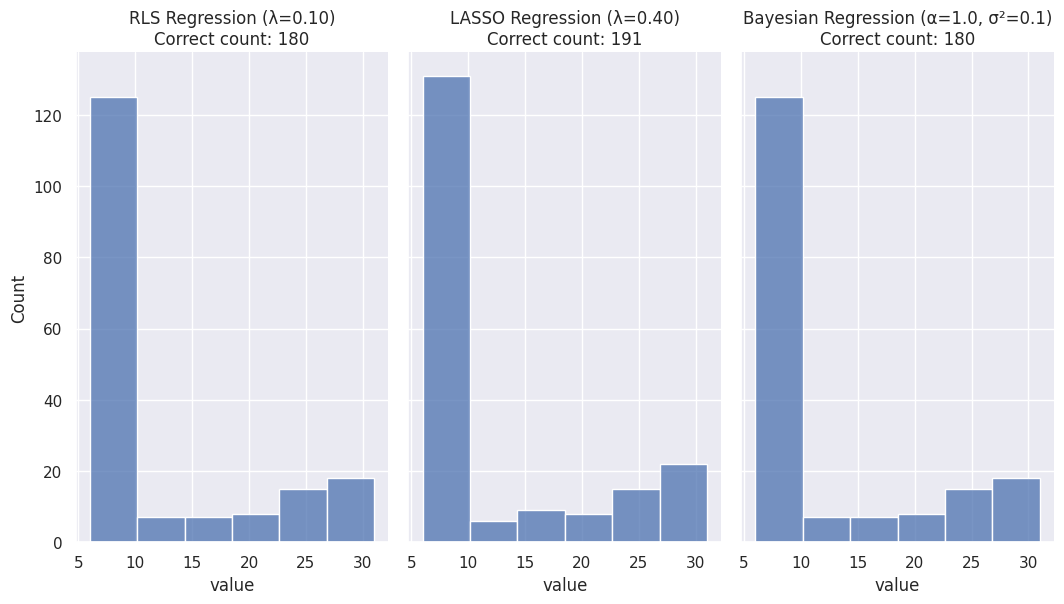

In [127]:
models_3 = [best_rls, best_lasso, best_bayes]
fit_predict_plot_count(models_3, phi=phi)